In [2]:
import random
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import numpy as np
pd.options.display.max_colwidth = 1000
pd.options.mode.chained_assignment = None


##### Load Data

In [3]:
df = pd.read_excel('../data_processed/women_ordinary_people.xlsx')

In [4]:
df.head()

,text,name,created_at,gender,ethnic,label,sentiment,sentiment_score
0,malala banning girl school taliban also arresting champions education matiullahwesa founded penpath pro,AfgEducation,2023-03-29,female,hazara,1,neutral,0.000000
1,since days afghan girl education centers closed afghanistan quality education power transform societies single generation afghan girl women need quality education need support help formal education let afghan girl learn,AfgEducation,2023-03-29,female,hazara,1,negative,-0.085714
2,core problem afghanistan conflicts lack education also core solution afghanistan conflicts education afghan girl women also part afg need edu right edu working alternative way facilitate education afghan girl women,AfgEducation,2023-03-28,female,hazara,1,positive,0.285714
3,matiullahwesa voice afghan generation peaceful education activist want education afghanistan also obligation rise voice afghan girl women education afghanistan relaesematiullahwesa let afghan girl learn,AfgEducation,2023-03-28,female,hazara,1,positive,0.250000
4,enemy ignorance work education afghans solution afghanistans miseries education educate encourage afghans study work educate afghans let afghan girl learn,AfgEducation,2023-03-28,female,hazara,1,neutral,0.000000


##### Drop Null, Empty and NaN valeus

In [5]:
df.dropna(subset=['text'], inplace=True) # remove nan values
df.drop_duplicates(subset=['text'], inplace=True) # remove duplicates


##### Clean Data

In [6]:
df['text'] = df['text'].str.replace('&amp;', ' ')
def clean_tweet_text(text):
    # Check for null or NaN values
    if pd.isnull(text):
        return text
    # Remove URL
    text = re.sub(r'http\S+', '', text)
    
    # Remove RT (retweet) tag
    text = text.replace('RT', '')
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove special characters and punctuations, and add a space after removing them
    text = re.sub(r'[^\w\s]', '', text)

    # Remove hashtags
    text = re.sub(r'#(\w+)', '', str(text))
    # Remove extra spaces
    text = ' '.join(text.split())
    
    # Convert to lowercase
    text = text.lower()
    
    return text
# Apply the cleaning function to 'text' column
df['text'] = df['text'].apply(clean_tweet_text)


In [7]:
# df = pd.read_excel('../data_processed/men_ordinary_people.xlsx')

In [8]:
df[['text']].sample(5)

,text
25872,sara bloody axes sharp axes childkilling axes misogynistic axes wild axes hands demon homeland drowned mourning crying stop hazara genocide
2340,prkhh ghzl najwaa shazya tanzeela tamana malikamalika hosnawardak najwa says dont accept
19656,zabehulah download republic project shame president ghanis project talab ziri bushka alone explodes commits suicide
34346,austin mayerr helmandafghanistan
21607,commemorating struggles hazara women international women day thanks citizens voice stop hazara genocide


##### Remove Text Less then 30 characters

In [9]:
df = df[df['text'].str.len() >=30]

##### Remove Empty Rows

In [10]:
def remove_empty_rows(df):
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Remove rows with empty values in the column
        df = df[df[column].notna() & df[column].astype(str).str.strip().ne('')]
    return df

df = remove_empty_rows(df)


##### Remove All Null Values

In [11]:
def remove_null_columns(df):
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Check if the column contains any null values
        if df[column].isnull().any():
            # If any null value exists, drop the column
            df = df.drop(column, axis=1)
    return df
df = remove_null_columns(df)


##### Remove Stopwords

In [12]:
from nltk.corpus import stopwords
import nltk

def remove_stopwords(df):
    stop_words = set(stopwords.words('english'))
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    return df

df = remove_stopwords(df)


##### Convert Timezone

In [13]:
# df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce').dt.date.astype(str)

In [14]:
df.sample(4)

,text,name,created_at,gender,ethnic,label,sentiment,sentiment_score
8767,thqyqt hasanaliadalat massoudakohist p sarabi worldguyana womenaidafghan misaq keyan khurasani malikyeganeh first wipe bloody hands think condemning others,sumaiafrotan,2022-09-25,female,tajik,1,negative,-0.275000
13954,amirhosein hamid balkh hengamehamirii may souls rest peace memories live hearts stop hazara genocide,amir70hosein,2022-10-17,female,hazara,0,positive,0.136364
15369,please voice voice fighters sending messages solidarity,AmiriWahida,2022-07-28,female,tajik,0,neutral,0.000000
41822,metmaeen million dollars zakat hajj mecca medina pakistan america become muslim dollar become halal tax infidels work may god turn poison descendants shame modesty know,rangeeza,2023-04-24,female,tajik,0,neutral,0.000000


In [15]:
df.sample(4)

,text,name,created_at,gender,ethnic,label,sentiment,sentiment_score
32877,visitafg corner kabul city mujtabakayhan,maroaxl,2023-02-16,female,pashtun,0,neutral,0.000000
26094,yeganafg general amnesty taliban lie torn asadullah commander kasht border brigade captured taliban seven days dab goli area center khost province,Hazara32674235,2023-03-16,female,hazara,0,negative,-0.025000
39775,punjab country get rid potatoes get space get punjab country liar dishonest punjab said dishonest traitor poor people punjab punjab,RanaA8989,2023-04-10,female,tajik,0,negative,-0.333333
18991,twitter suspended amtullahsalehs account responded secpompeos recent remarks expresident ashrafghani freedom expression says believe free speech want experience write shameful,DarmalHeela,2023-01-16,female,pashtun,0,positive,0.200000


##### Convert Timezone to datetime

In [16]:
df.head()

,text,name,created_at,gender,ethnic,label,sentiment,sentiment_score
0,malala banning girl school taliban also arresting champions education matiullahwesa founded penpath pro,AfgEducation,2023-03-29,female,hazara,1,neutral,0.000000
1,since days afghan girl education centers closed afghanistan quality education power transform societies single generation afghan girl women need quality education need support help formal education let afghan girl learn,AfgEducation,2023-03-29,female,hazara,1,negative,-0.085714
2,core problem afghanistan conflicts lack education also core solution afghanistan conflicts education afghan girl women also part afg need edu right edu working alternative way facilitate education afghan girl women,AfgEducation,2023-03-28,female,hazara,1,positive,0.285714
3,matiullahwesa voice afghan generation peaceful education activist want education afghanistan also obligation rise voice afghan girl women education afghanistan relaesematiullahwesa let afghan girl learn,AfgEducation,2023-03-28,female,hazara,1,positive,0.250000
4,enemy ignorance work education afghans solution afghanistans miseries education educate encourage afghans study work educate afghans let afghan girl learn,AfgEducation,2023-03-28,female,hazara,1,neutral,0.000000


##### Drop the whole rows which is >=2020

In [17]:
df["created_at"] = pd.to_datetime(df["created_at"], format="%Y-%m-%d")
filtered_df = df[df["created_at"].dt.year >= 2020]
df.drop(df[df["created_at"].dt.year <= 2020].index, inplace=True)

##### Remove Great March, 30

In [18]:
df.shape

(57688, 8)

In [19]:
df.sample(4)

,text,name,created_at,gender,ethnic,label,sentiment,sentiment_score
52513,nbm look great history hazaras land called afghanistan stop hazara genocide,Rahmmat_H,2022-12-03,female,hazara,0,positive,0.8
32376,khalowardak eid mubarak exile eid mubarak ones cant hug fathers kiss hands mothers akhtar,maroaxl,2023-04-21,female,pashtun,0,neutral,0.0
44312,meenasaifi kaka kabir ur asking advance questions,Saihya__,2023-04-15,female,pashtun,0,neutral,0.0
2873,radorhman haha brother god forbid,AyeeshaSediqi,2022-09-22,female,pashtun,0,positive,0.2


##### Check How Many accounts are there

In [20]:
len(df['name'].unique())

54

##### Labeling Process

In [21]:
def label_tweets(text):
    keywords = ['education', 'school', 'university', 'women', 'girl']
    for keyword in keywords:
        if keyword in text.lower():
            return 1
    return 0
df = df.copy()
df['label'] = df['text'].apply(label_tweets)

##### Sentiment Analysis

In [22]:
x = df['text']
sentiment_labels = []
sentiment_scores = []
for tweet in x:
    # Create a TextBlob object
    blob = TextBlob(tweet)
    # Get the sentiment polarity (-1 to 1)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        sentiment = 'positive'
    elif polarity < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    sentiment_labels.append(sentiment)
    sentiment_scores.append(polarity)
# Add the sentiment labels and scores as new columns in the DataFrame
df['sentiment'] = sentiment_labels
df['sentiment_score'] = sentiment_scores

##### Data Set Summary

In [23]:
sentiment_counts = df['sentiment'].value_counts()
print("Sentiment Counts:\n", sentiment_counts)
total_counts = sentiment_counts['positive'] + sentiment_counts['negative']
print("Total Counts:", total_counts)

Sentiment Counts:
 sentiment
neutral     24221
positive    21488
negative    11979
Name: count, dtype: int64
Total Counts: 33467


##### Calculate positive tweets and percentage for women, single user

In [24]:
women_positive_count = df[(df['gender'] == 'female') & (df['sentiment'] == 'positive')].shape[0]
women_total_count = df[df['gender'] == 'female'].shape[0]
women_positive_percentage = (women_positive_count / women_total_count) * 100
# Print the results
print("Positive tweets from men:", women_positive_count, "(", women_positive_percentage, "%)")

Positive tweets from men: 21488 ( 37.24864789904313 %)


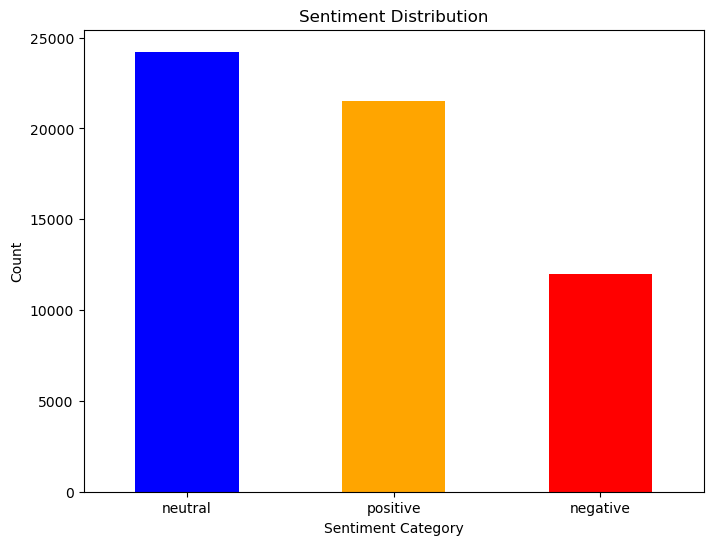

Sentiment Distribution: 33467


In [25]:
# Define custom colors for sentiment categories
colors = {'negative': 'red', 'neutral': 'blue', 'positive': 'orange'}

# Calculate sentiment counts
sentiment_counts = df['sentiment'].value_counts()

# Plot the sentiment counts with custom colors
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=[colors.get(x, 'gray') for x in sentiment_counts.index])
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.title('Sentiment Distribution')
plt.show()

# Calculate total counts
total_counts = sentiment_counts['positive'] + sentiment_counts['negative']
print("Sentiment Distribution:", total_counts)


##### Content Analysis

In [26]:
df_edu = df.loc[df['label'] == 1]
print("Number of tweets in favor of education: ", len(df_edu))

Number of tweets in favor of education:  9727


##### Code Schema

In [27]:
coding_scheme = {
'women': ['women', 'woman', 'female', 'feminine', 'girl', 'lady'],
'education': ['education', 'educational', 'learning', 'academics', 'knowledge'],
'school': ['school', 'classroom', 'teacher', 'students', 'curriculum'],
'university': ['university', 'college', 'higher education', 'academia', 'campus'],
'access': ['access', 'opportunity', 'enrollment', 'attendance', 'entry'],
'quality': ['quality', 'standard', 'curriculum', 'teaching', 'learning'],
'benefits': ['benefit', 'advantage', 'improvement', 'progress'],
'barriers': ['barrier', 'restriction', 'obstacle', 'challenge', 'difficulty'],
'empowerment': ['empower', 'empowering', 'confidence', 'self-esteem', 'agency'],
'gender': ['gender', 'discriminatioan', 'inequality', 'feminism', 'patriarchy']
}

# Define a function to apply the coding scheme to each tweet
def apply_coding_scheme(text):
    codes = []
    for code, keywords in coding_scheme.items():
        for keyword in keywords:
            if keyword in text.lower():
                codes.append(code)
    return codes

# Apply the coding scheme to the text column and create a new column for the codes
df_edu['codes'] = df_edu['text'].apply(apply_coding_scheme)

In [28]:
df_edu[['text','sentiment','sentiment_score','gender','label','codes']].sample(5)

,text,sentiment,sentiment_score,gender,label,codes
24167,remember educated student alfath high school kabul didnt know difference tajik pashtun hazara classmates th grade close friends pashtuns kandahar khost paktia uzbek faryab idea index separates us today even yearold child fights nationality,positive,0.160000,female,1,[school]
31267,movementofchan erased still fighting free afghan womenbread work freedom fawziakoofi,positive,0.400000,female,1,[women]
34954,hamasabadakhsh stand women afghanistan,neutral,0.000000,female,1,[women]
8253,barish unhumanrights kabuliold massoudakohist womenaidafghan zala zazai gheyasiyasamin amnestyusa unamanews unhcrafg every day protestors soldiers security forces massacred life become worth less zero,positive,0.066667,female,1,[women]
10523,jawid allen biggest afghan woman ngo women afghan women stole million women afghanistan kept shelters many poor hazara women children begging streets please retweet stop hazara genocide,positive,0.050000,female,1,"[women, women]"


##### Visualization

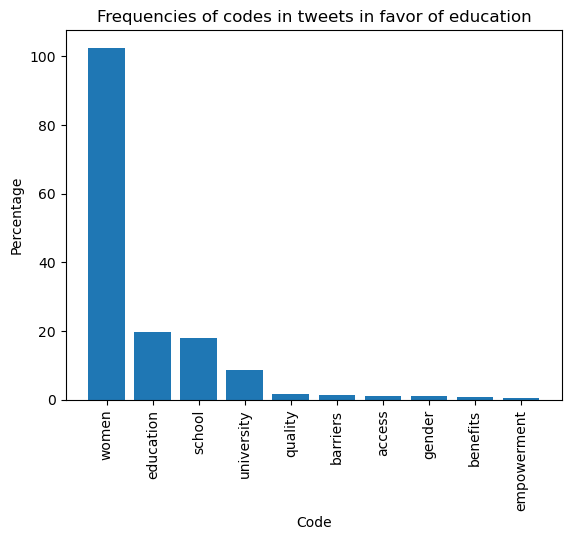

In [29]:
df_codes = df_edu.explode('codes')
# Calculate the frequency and percentage of each code
code_freq = df_codes['codes'].value_counts()
code_perc = code_freq / len(df_edu) * 100
# Plot the code frequencies as a bar chart
plt.bar(code_perc.index, code_perc.values)
plt.title('Frequencies of codes in tweets in favor of education')
plt.xlabel('Code')
plt.xticks(rotation=90)
plt.ylabel('Percentage')
plt.show()

In [30]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()
# Loop through each keyword and calculate the sentiment of tweets containing that keyword
for keyword in ['women', 'education', 'school', 'university', 'girl']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(keyword_tweets.groupby('sentiment')['text'].count())


Sentiment analysis of tweets containing the keyword 'women':
sentiment
negative    1100
neutral     2146
positive    2408
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'education':
sentiment
negative    316
neutral     527
positive    798
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'school':
sentiment
negative    348
neutral     449
positive    549
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'university':
sentiment
negative    188
neutral     263
positive    307
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'girl':
sentiment
negative     726
neutral     1240
positive    1332
Name: text, dtype: int64


In [31]:
for keyword in ['women education']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(keyword_tweets.groupby('sentiment')['text'].count())

Sentiment analysis of tweets containing the keyword 'women education':
sentiment
negative    10
neutral     23
positive    27
Name: text, dtype: int64


In [32]:
for keyword in ['women education']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    sentiment_counts = keyword_tweets.groupby('sentiment')['text'].count()
    total_count = sentiment_counts.sum()
    sentiment_percentages = (sentiment_counts / total_count) * 100
    result = sentiment_counts.astype(str) + ' (' + sentiment_percentages.round(1).astype(str) + '%)'
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(result)


Sentiment analysis of tweets containing the keyword 'women education':
sentiment
negative    10 (16.7%)
neutral     23 (38.3%)
positive    27 (45.0%)
Name: text, dtype: object


##### Average sentiment

In [33]:
import random
from textblob import TextBlob
keywords = ['women education']
all_tweets = [row['text'] for _, row in df.iterrows() if any(keyword in row['text'] for keyword in keywords)]
sample_tweets = random.sample(all_tweets, k=min(10, len(all_tweets)))
mean_sentiment = sum(TextBlob(tweet).sentiment.polarity for tweet in all_tweets) / len(all_tweets) if all_tweets else 0
print(f"Average sentiment score for all tweets: {mean_sentiment}")


Average sentiment score for all tweets: 0.04169113756613756


##### Sentiment Category

In [34]:
import numpy as np
category_sentiment = df_edu.groupby(df_edu['codes'].apply(tuple))['text'].apply(lambda x: np.mean([TextBlob(tweet).sentiment.polarity for tweet in x]))
print("Sentiment Scores by Category:")
category_sentiment.head()

Sentiment Scores by Category:


codes
(education,)              0.030180
(education, access)      -0.006429
(education, barriers)    -0.032927
(education, benefits)    -0.031393
(education, education)    0.093032
Name: text, dtype: float64

##### Calculate the sentiment scores for all tweets

In [35]:
sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in df['text']]
# Compare the sentiment distributions using a t-test
t_stat, p_value = stats.ttest_1samp(sentiment_scores, 0)
print("Comparison of Sentiment Women Ordinary People:")
print("T-statistic:", t_stat)
print("P-value:", p_value)


Comparison of Sentiment Women Ordinary People:
T-statistic: 54.53734918247717
P-value: 0.0


In [36]:
men_education_tweets = df[df['text'].str.contains('women education', case=False)]
sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in men_education_tweets['text']]
t_stat, p_value = stats.ttest_1samp(sentiment_scores, 0)
print("Comparison of Sentiment for Women Education Tweets:")
print("T-statistic:", t_stat)
print("P-value:", p_value)

Comparison of Sentiment for Women Education Tweets:
T-statistic: 1.5827050792224808
P-value: 0.11883500035121558


#### Calculate the sentiment scores for tweets containing each keyword

In [37]:
keyword_sentiment = {}
for keyword in keywords:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)]
    sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in keyword_tweets['text']]
    keyword_sentiment[keyword] = np.mean(sentiment_scores)
print("Sentiment Scores by Keyword:")
for keyword, sentiment_score in keyword_sentiment.items():
    print(f"{keyword}: {sentiment_score}")


Sentiment Scores by Keyword:
women education: 0.04169113756613758


##### Chi-square test of independence

In [38]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df['gender'], df['label'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)
print("Chi-square Test of Independence:")
print("Chi-square:", chi2)
print("P-value:", p_value)

Chi-square Test of Independence:
Chi-square: 0.0
P-value: 1.0


##### Create a cross-tabulation between sentiment and gender

In [39]:
cross_tab = pd.crosstab(df['sentiment'], df['gender'])
# Print the cross-tabulation
print("Cross-Tabulation of Sentiment and Gender:")
print(cross_tab)

Cross-Tabulation of Sentiment and Gender:
gender     female
sentiment        
negative    11979
neutral     24221
positive    21488


In [40]:
cross_tab = pd.crosstab(df['gender'], df['label'])
# Print the cross-tabulation
print("Cross-Tabulation of Gender and Label:")
print(cross_tab)

Cross-Tabulation of Gender and Label:
label       0     1
gender             
female  47961  9727


##### Calculate descriptive statistics for women


In [41]:
men_sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in df[df['gender'] == 'female']['text']]
# Calculate descriptive statistics for men
men_mean_sentiment = np.mean(men_sentiment_scores)
men_median_sentiment = np.median(men_sentiment_scores)
men_std_sentiment = np.std(men_sentiment_scores)
men_quartiles_sentiment = np.percentile(men_sentiment_scores, [25, 50, 75])

print("Descriptive Statistics for men ordinary people:")
print("Mean Sentiment:", men_mean_sentiment)
print("Median Sentiment:", men_median_sentiment)
print("Standard Deviation of Sentiment:", men_std_sentiment)
print("Quartiles of Sentiment:", men_quartiles_sentiment)

Descriptive Statistics for men ordinary people:
Mean Sentiment: 0.06375562621593164
Median Sentiment: 0.0
Standard Deviation of Sentiment: 0.28077825322328437
Quartiles of Sentiment: [0.         0.         0.16666667]


##### Frequent Words

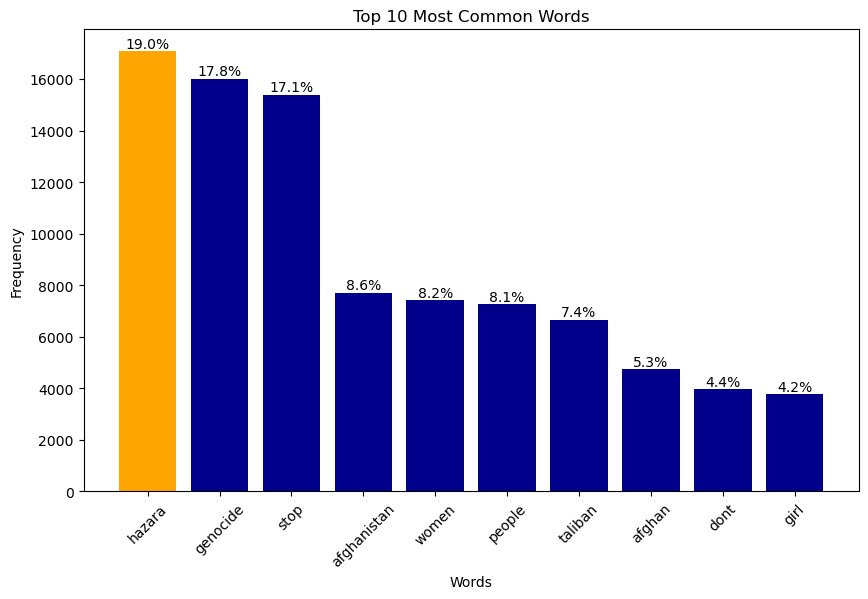

In [42]:
import matplotlib.pyplot as plt
from collections import Counter

# Combine all the text into a single string
all_text = ' '.join(df['text'].tolist())

# Split the text into individual words
all_words = all_text.split()

# Count the occurrences of each word
word_counts = Counter(all_words)

# Retrieve the most common words
most_common_words = word_counts.most_common(10)

# Extract the words and their frequencies
words = [word for word, count in most_common_words]
frequencies = [count for word, count in most_common_words]

# Calculate the total frequency of all words
total_frequency = sum(frequencies)

# Calculate the percentages
percentages = [count / total_frequency * 100 for count in frequencies]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar chart for the most common words
bars = ax.bar(words, frequencies, color=['orange', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue'])

# Add labels and title
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
ax.set_title('Top 10 Most Common Words')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add percentage labels above each bar
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha='center', va='bottom')

# Show the chart
plt.show()


In [43]:
for word, count in most_common_words:
    print(f'{word}: {count}')


hazara: 17072
genocide: 16023
stop: 15402
afghanistan: 7719
women: 7425
people: 7268
taliban: 6673
afghan: 4759
dont: 3963
girl: 3774


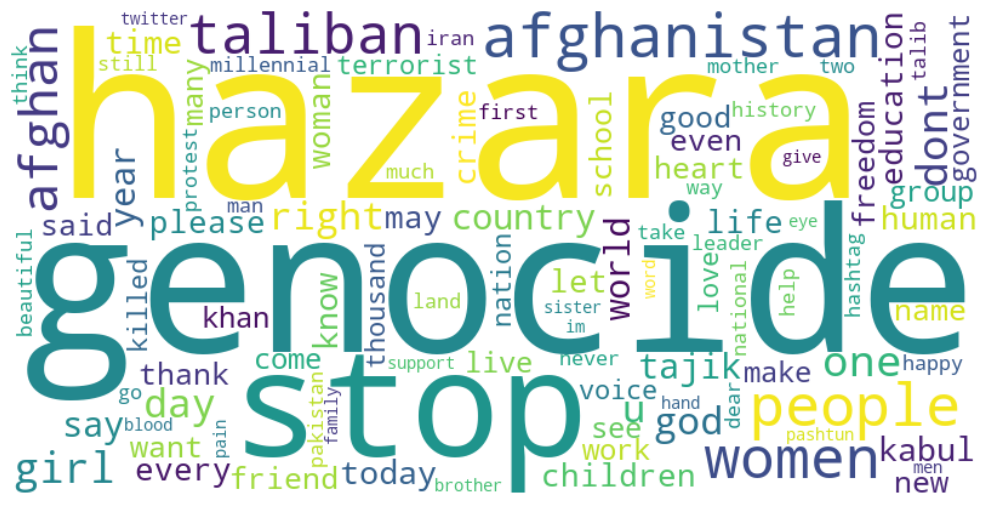

In [51]:
from wordcloud import WordCloud
text = ' '.join(df['text'])
# Create a WordCloud object with customized options
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                      max_words=100, contour_width=3, contour_color='steelblue',
                      prefer_horizontal=0.8, relative_scaling=0.5,
                      collocations=False).generate(text)
# Add a central word
wordcloud.generate_from_text("Afghanistan")
# Manipulate font sizes for the central word and other words
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                      max_words=100, contour_width=3, contour_color='steelblue',
                      prefer_horizontal=0.8, relative_scaling=0.5,
                      collocations=False).generate(text)
wordcloud.words_["Afghanistan"] = 80  # Set font size for the central word
# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()


##### Time Series

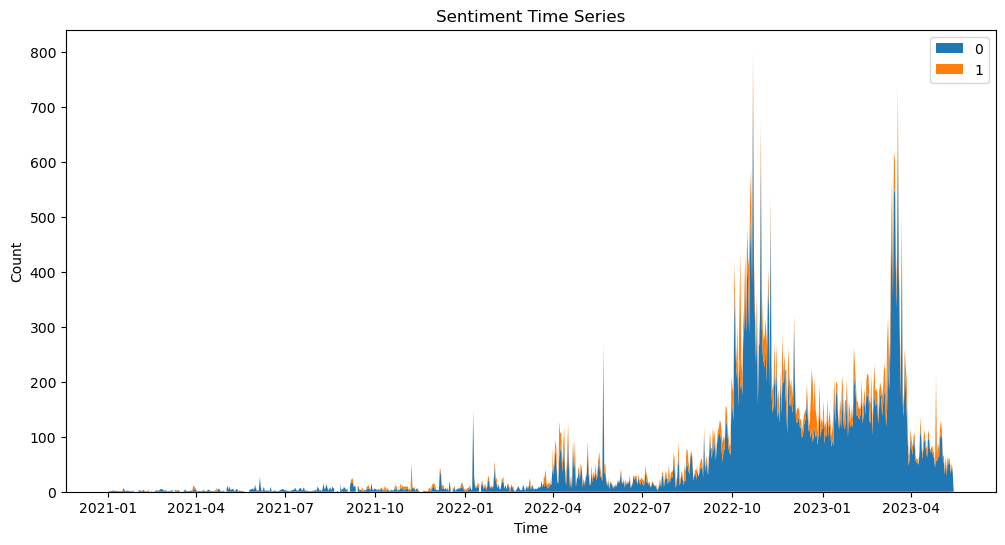

In [44]:

sentiment_counts = df.groupby(['created_at', 'label']).size().unstack()
# Extract the time periods and convert them to datetime objects
time_periods = pd.to_datetime(sentiment_counts.index)
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))
# Plot the stacked area plot for sentiment categories
ax.stackplot(time_periods, sentiment_counts.T, labels=sentiment_counts.columns)
# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.set_title('Sentiment Time Series')
# Add legend
ax.legend()
# Show the chart
plt.show()

##### Frequent Tweet

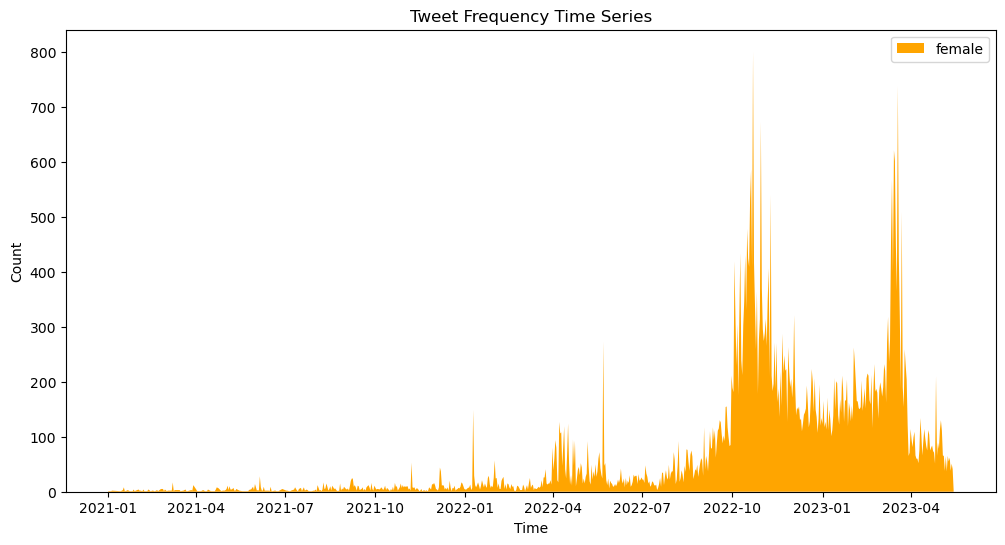

In [45]:
# Group the data by 'created_at' and 'gender', and count the number of tweets for each gender
freq_counts = df.groupby(['created_at', 'gender']).size().unstack()

# Extract the time periods and convert them to datetime objects
time_periods = pd.to_datetime(freq_counts.index)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the stacked area plot for genders
ax.stackplot(time_periods, freq_counts.T, labels=freq_counts.columns, colors=['orange', 'darkblue'])

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.set_title('Tweet Frequency Time Series')

# Add legend
ax.legend()

# Show the chart
plt.show()


In [46]:
df[['text']].sample(7)

,text
11285,fatimahaidarii noorband sure message
22636,abdal exactly stop hazara genocide
29571,taliban kandahar rank kankuro daikandi rank kandahar herat nimroz kabul zabul ghor panjshir ghazni farah badghis maidan wardak helmand daykundi
55297,sardarrrgom optional apparently like point surrounded circle
18750,afintlbrk lying media dont real news us reduced dignity zero kolabi media
12525,blind eyes enemies hazara always powerful strong stop hazara genocide
43411,schizophrenic must u said un revolting insult pashtuns pakistan destroy help tb u drunk u taken drugs consequences wasnt mistake ur apology isnt enough resign get stuffed


In [47]:
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce').dt.date.astype(str)

In [48]:
df.sample(5)

,text,name,created_at,gender,ethnic,label,sentiment,sentiment_score
46236,zakerershad gitis stature bends hayat stops breathing enough eternally ashamed human beings see stop,sediqullahsadi5,2022-10-17,female,hazara,0,neutral,0.000000
49926,nkashrafi get well soon brother posting ground realities doesnt mean support taliban form resistance project funded activist wont get truly free enough courage conscious,WazhmaAyoubi,2022-07-30,female,pashtun,0,positive,0.046875
15085,afghanistans heroes protested roads kabul killing kaj students,AmiriWahida,2022-10-01,female,tajik,0,neutral,0.000000
28645,detentionofthemilitary brutal taliban arrested national security officer former government named najibullah achakzai kandahar night thursday january transferred unknown place family former soldier says know taliban taken freenajibullahachekzai,maryam,2022-12-30,female,tajik,0,negative,-0.243750
23064,like ansaris hibos kor omar hundreds spies reach ground beloved commander popular worldwide,Frah_Frah1,2022-09-09,female,tajik,0,positive,0.650000


In [49]:
df.shape

(57688, 8)

In [50]:
df.to_excel('../data_processed/women_ordinary_people.xlsx',index=False)